In [349]:
#libraries
import sys 
import pandas as pd 
import matplotlib 
import numpy as np 
import scipy as sp 
import IPython
from IPython import display  
import sklearn 
import random
import time
import graphviz
import warnings
warnings.filterwarnings('ignore')

In [350]:
#algorithms
from sklearn import tree

#helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

#visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns; sns.set()
from pandas.tools.plotting import scatter_matrix

#vizualization defaults
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [351]:
#import raw datasets from Kaggle
raw_data = pd.read_csv('train.csv')
validation_data  = pd.read_csv('test.csv')

#dublicate training data to preserve original
training_data = raw_data.copy(deep = True)

#reference both data sets for cleaning
clean_data = [training_data, validation_data]

#preview for initial sweep
print (raw_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


In [352]:
#see how much data is blank
print("-"*15)
print('null training columns:\n', training_data.isnull().sum())
print("-"*15)

print('null validation columns:\n', validation_data.isnull().sum())
print("-"*15)


---------------
null training columns:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
---------------
null validation columns:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
---------------


In [353]:
#fill in missing data or remove the row and drop unneeded columns
for dataset in clean_data:    
    dataset['Age'].fillna(dataset['Age'].mean(), inplace = True)
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    dataset['Fare'].fillna(dataset['Fare'].mean(), inplace = True)
    
drop_column1 = ['PassengerId', 'Ticket', 'Cabin']
training_data.drop(drop_column1, axis=1, inplace = True)

drop_column2 = ['Cabin']
validation_data.drop(drop_column2, axis=1, inplace = True)

print(training_data.isnull().sum())
print("-"*15)
print(validation_data.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
---------------
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [354]:
#feature engineering
for dataset in clean_data:    
    #discrete data
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1
    dataset['Alone'] = 1 #initialize
    dataset['Alone'].loc[dataset['FamilySize'] > 1] = 0 #true/false

    #parse out and create column Prefix from Name
    dataset['Prefix'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

    #continuous data
    #qcut are quantiles or giving a range to each bin
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

    #cut is individual bins for each value
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)
    
#group outlier Prefix's
print(training_data['Prefix'].value_counts())
stat_min = 6
title_names = (training_data['Prefix'].value_counts() < stat_min) #Prefix index true/false
print("-"*15)

#apply Lambda is like a find and replace
training_data['Prefix'] = training_data['Prefix'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(training_data['Prefix'].value_counts())
print("-"*10)


#preview data again
raw_data.info()
print("-"*15)
validation_data.info()
print("-"*15)
#raw_data.sample(15)

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Don               1
Lady              1
Jonkheer          1
the Countess      1
Sir               1
Capt              1
Mme               1
Name: Prefix, dtype: int64
---------------
Mr        517
Miss      182
Mrs       125
Master     40
Misc       14
Dr          7
Rev         6
Name: Prefix, dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null o

In [355]:
#categorize using Label Encoder

#categorical data
label = LabelEncoder()
for dataset in clean_data:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Prefix_Code'] = label.fit_transform(dataset['Prefix'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])


#defining the target y variables
Target = ['Survived']

#defining feature selection x variables
training_data_x = ['Sex','Pclass', 'Embarked', 'Prefix','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'Alone'] #names for the charts
training_data_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Prefix_Code','SibSp', 'Parch', 'Age', 'Fare'] #for algorithms
training_data_xy =  Target + training_data_x
print('Original X Y: ', training_data_xy, '\n')

#defining original w/bin feature to remove continuous variables
training_data_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Prefix_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
training_data_xy_bin = Target + training_data_x_bin
print('Bin X Y: ', training_data_xy_bin, '\n')


#defining dummy features ---------------------------------------------------------------REMOVE THIS????
training_data_dummy = pd.get_dummies(training_data[training_data_x])
training_data_x_dummy = training_data_dummy.columns.tolist()
training_data_xy_dummy = Target + training_data_x_dummy
print('Dummy X Y: ', training_data_xy_dummy, '\n')



training_data_dummy.head()

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Prefix', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'Alone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Prefix_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'Alone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Prefix_Dr', 'Prefix_Master', 'Prefix_Misc', 'Prefix_Miss', 'Prefix_Mr', 'Prefix_Mrs', 'Prefix_Rev'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,Alone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Prefix_Dr,Prefix_Master,Prefix_Misc,Prefix_Miss,Prefix_Mr,Prefix_Mrs,Prefix_Rev
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,0,1,0,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,0,1,0
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,0,1,0,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,0,1,0
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,0,1,0,0


In [356]:
print('null training columns: \n', training_data.isnull().sum())
print("-"*15)
print (training_data.info())
print("-"*15)

print('null validation columns: \n', validation_data.isnull().sum())
print("-"*15)
print (validation_data.info())
print("-"*15)

raw_data.describe(include = 'all')

null training columns: 
 Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
Alone            0
Prefix           0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Prefix_Code      0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Embarked         891 non-null object
FamilySize       891 non-null int64
Alone            891 non-null int64
Prefix           891 non-null object
FareBin          891 non-null category
A

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Troutt, Miss. Edwina Celia ""Winnie""",male,NaN,NaN,NaN,1601,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [357]:
#split training dataframe into training and test data
#random_state is a seed generator
training1_x, testing1_x, training1_y, testing1_y = model_selection.train_test_split(training_data[training_data_x_calc], training_data[Target], random_state = 0)
training1_x_bin, testing1_x_bin, training1_y_bin, testing1_y_bin = model_selection.train_test_split(training_data[training_data_x_bin], training_data[Target] , random_state = 0)
training1_x_dummy, testing1_x_dummy, training1_y_dummy, testing1_y_dummy = model_selection.train_test_split(training_data_dummy[training_data_x_dummy], training_data[Target], random_state = 0)


print("training Shape: {}".format(training_data.shape))
print("training1 Shape: {}".format(training1_x.shape))
print("testing1 Shape: {}".format(testing1_x.shape))

training1_x_bin.head()

training Shape: (891, 19)
training1 Shape: (668, 8)
testing1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Prefix_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,4,1,1,0
68,0,3,2,3,7,1,1
253,1,3,2,4,2,1,2
320,1,3,2,4,1,1,0
706,0,2,2,5,1,2,1


In [358]:
#discrete variable correlation against survival according to group
for x in training_data_x:
    if training_data[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print(training_data[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*15, '\n')
        

#using crosstabs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html
print(pd.crosstab(training_data['Prefix'],training_data[Target[0]]))

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
--------------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
--------------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
--------------- 

Survival Correlation by: Prefix
   Prefix  Survived
0      Dr  0.428571
1  Master  0.575000
2    Misc  0.642857
3    Miss  0.697802
4      Mr  0.156673
5     Mrs  0.792000
6     Rev  0.000000
--------------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
--------------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
--------------- 

Survival Correl

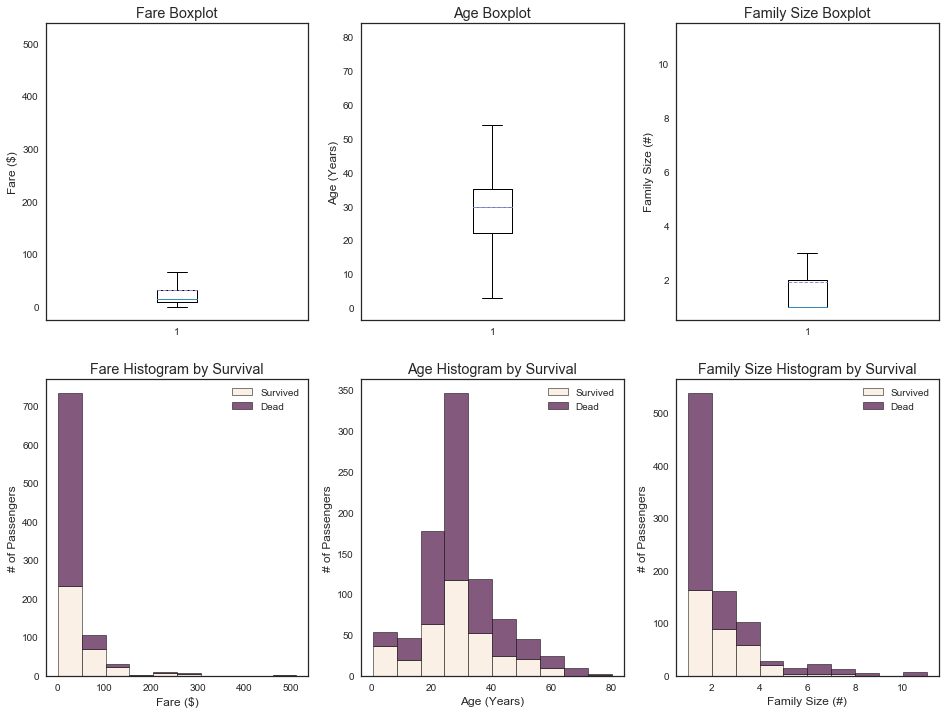

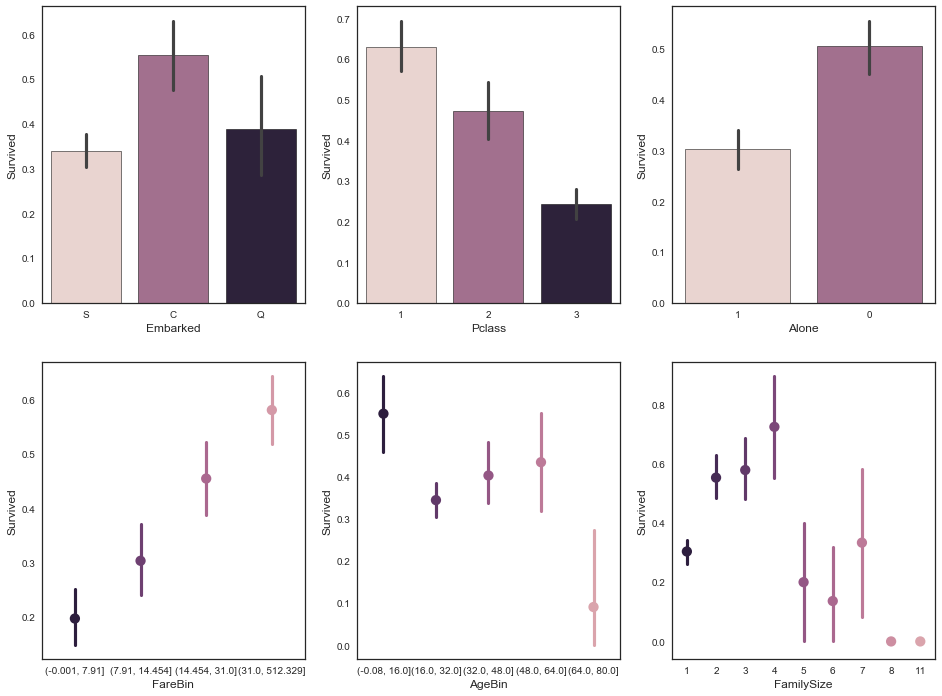

In [359]:
#visualization start

#quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=training_data['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(training_data['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(training_data['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [training_data[training_data['Survived']==1]['Fare'], training_data[training_data['Survived']==0]['Fare']], 
         stacked=True, color = ['linen', 'xkcd:dull purple'],label = ['Survived','Dead'], edgecolor='black', linewidth=.5)
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [training_data[training_data['Survived']==1]['Age'], training_data[training_data['Survived']==0]['Age']], 
         stacked=True, color = ['linen', 'xkcd:dull purple'],label = ['Survived','Dead'], edgecolor='black', linewidth=.5)
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [training_data[training_data['Survived']==1]['FamilySize'], training_data[training_data['Survived']==0]['FamilySize']], 
         stacked=True,  color = ['linen', 'xkcd:dull purple'],label = ['Survived','Dead'],  edgecolor='black', linewidth=.5)
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

#seaborn multi-variable comparison
#columns versus survival
fig, saxis = plt.subplots(2, 3,figsize=(16,12))

bar_plot_colors = sns.cubehelix_palette(start = 0, n_colors = 3)
sns.barplot(x = 'Embarked', y = 'Survived', data=training_data, ax = saxis[0,0], palette = bar_plot_colors, edgecolor="black", linewidth=.5)
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=training_data, ax = saxis[0,1], palette = bar_plot_colors, edgecolor="black", linewidth=.5)
sns.barplot(x = 'Alone', y = 'Survived', order=[1,0], data=training_data, ax = saxis[0,2], palette = bar_plot_colors, edgecolor="black", linewidth=.5)

point_plot_colors1 = sns.cubehelix_palette(start = 0, n_colors = 5, reverse = True)
sns.pointplot(x = 'FareBin', y = 'Survived',  data=training_data, ax = saxis[1,0], palette = point_plot_colors1)
point_plot_colors2 = sns.cubehelix_palette(start = 0, n_colors = 6, reverse = True)
sns.pointplot(x = 'AgeBin', y = 'Survived',  data=training_data, ax = saxis[1,1], palette = point_plot_colors2)
point_plot_colors3 = sns.cubehelix_palette(start = 0, n_colors = 11, reverse = True)
sns.pointplot(x = 'FamilySize', y = 'Survived', data=training_data, ax = saxis[1,2], palette = point_plot_colors3)

Text(0.5,1,'Pclass vs Family Size Survival Comparison')

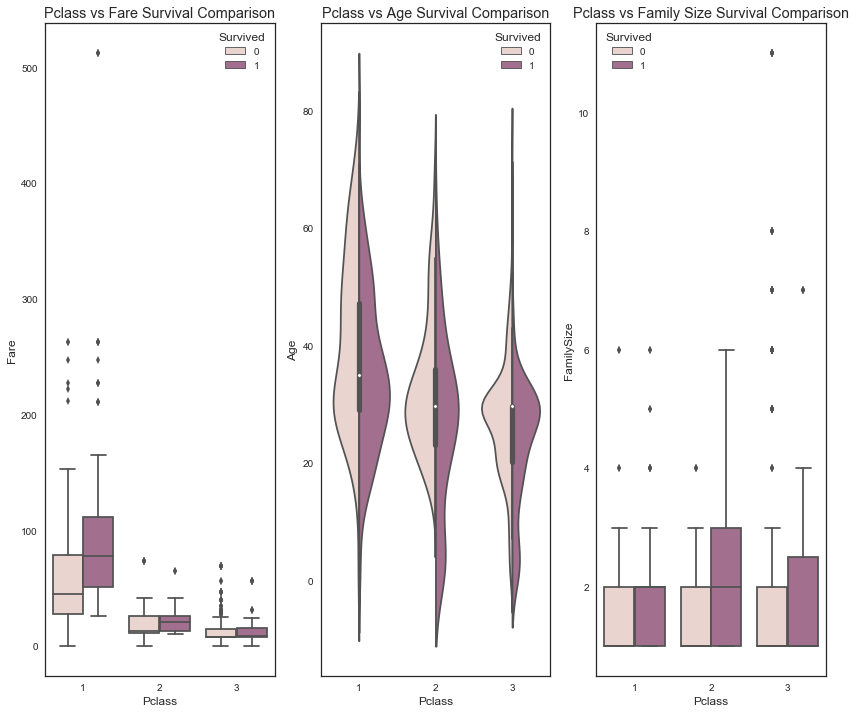

In [360]:
#qualitative distrobution: Pclass
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(14,12))

box_plot_colors = sns.cubehelix_palette(start = 0, n_colors = 3)
sns.boxplot(x = 'Pclass', y = 'Fare', hue = 'Survived', data = training_data, ax = axis1, palette = box_plot_colors)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived', data = training_data, split = True, ax = axis2, palette = box_plot_colors)
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x = 'Pclass', y ='FamilySize', hue = 'Survived', data = training_data, ax = axis3, palette = box_plot_colors)
axis3.set_title('Pclass vs Family Size Survival Comparison')

Text(0.5,1,'Sex vs Alone Survival Comparison')

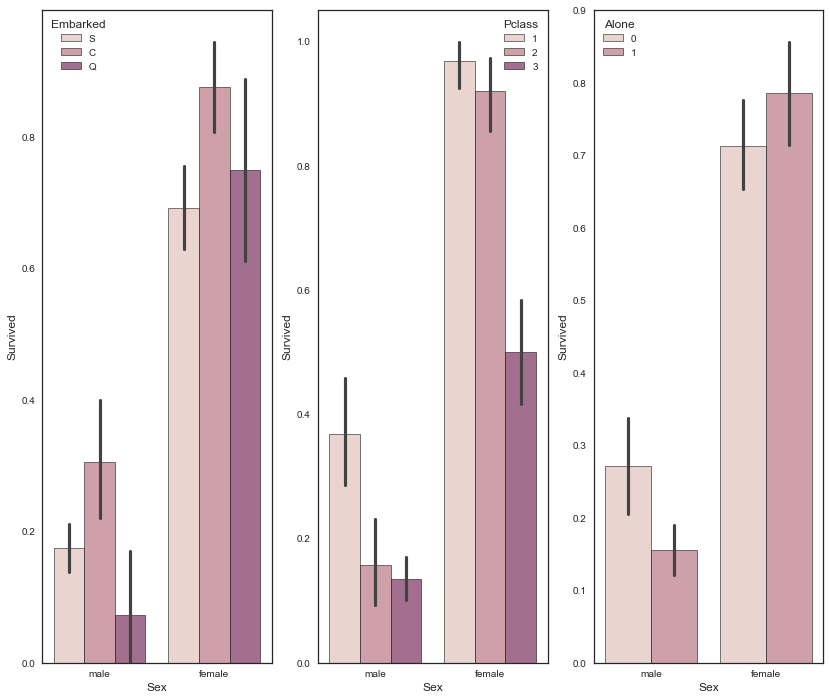

In [361]:
#qualitative distrobution: Sex
fig, qaxis = plt.subplots(1,3,figsize=(14,12))

sex_plot_colors = sns.cubehelix_palette(start = 0, n_colors = 5)
sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked', data=training_data, ax = qaxis[0], edgecolor="black", linewidth=.5, palette = sex_plot_colors)
axis1.set_title('Sex vs Embarked Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data=training_data, ax  = qaxis[1], edgecolor="black", linewidth=.5, palette = sex_plot_colors)
axis1.set_title('Sex vs Pclass Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Alone', data=training_data, ax  = qaxis[2], edgecolor="black", linewidth=.5, palette = sex_plot_colors)
axis1.set_title('Sex vs Alone Survival Comparison')


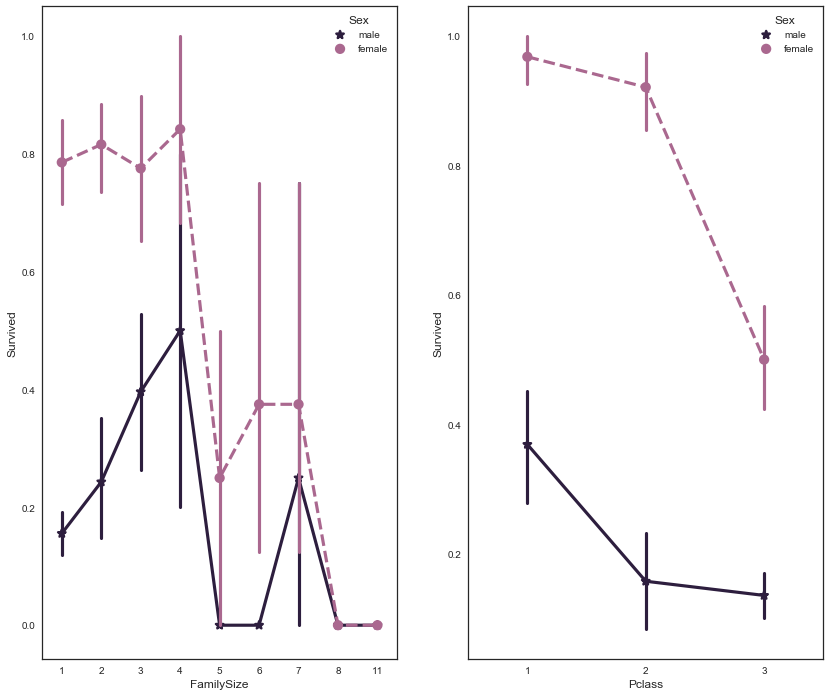

In [362]:
fig, (maxis1, maxis2) = plt.subplots(1, 2,figsize=(14,12))
family_sex_plot_colors = sns.cubehelix_palette(start = 0, n_colors = 3, reverse = True)

#family size and sex vs survival
sns.pointplot(x="FamilySize", y="Survived", hue="Sex", data=training_data,
               palette = family_sex_plot_colors,
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis1)

#class and sex vs survival
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=training_data,
              palette = family_sex_plot_colors,
              #palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis2)

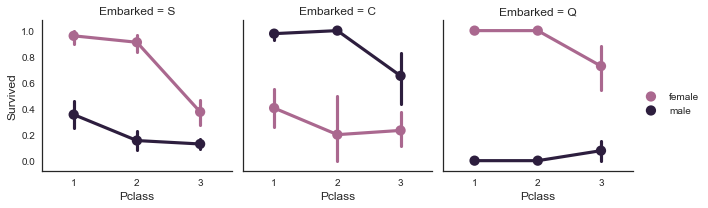

In [363]:
#embark port, sex, and class vs survival
embark_sex_class_plot_colors = sns.cubehelix_palette(start = 0, n_colors = 3, reverse = True)
e = sns.FacetGrid(training_data, col = 'Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=95.0, palette = embark_sex_class_plot_colors)
e.add_legend()

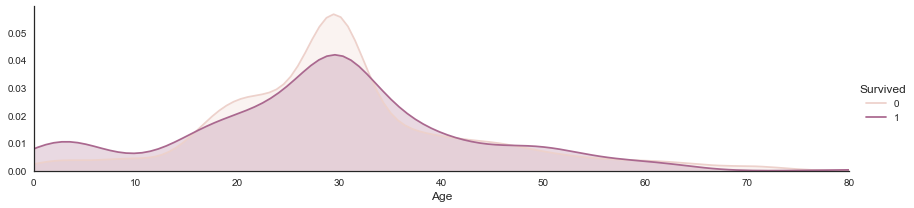

In [364]:
#percentage distrobution of age in survivors
survival_age_distro_plot_colors = sns.cubehelix_palette(start = 0, n_colors = 3)#, reverse = True)
a = sns.FacetGrid( training_data, hue = 'Survived', aspect=4, palette = survival_age_distro_plot_colors )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , training_data['Age'].max()))
a.add_legend()

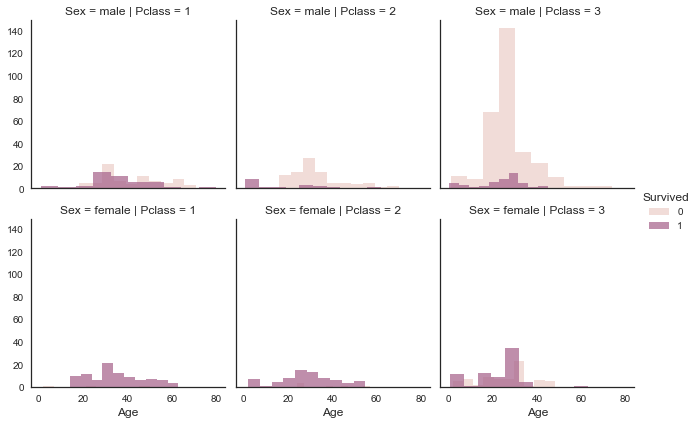

In [365]:
#class, sex, and age according to survival
class_sex_age_plot_colors = sns.cubehelix_palette(start = 0, n_colors = 3)#, reverse = True)
h = sns.FacetGrid(training_data, row = 'Sex', col = 'Pclass', hue = 'Survived', palette = class_sex_age_plot_colors)
h.map(plt.hist, 'Age', alpha = .75)
h.add_legend()

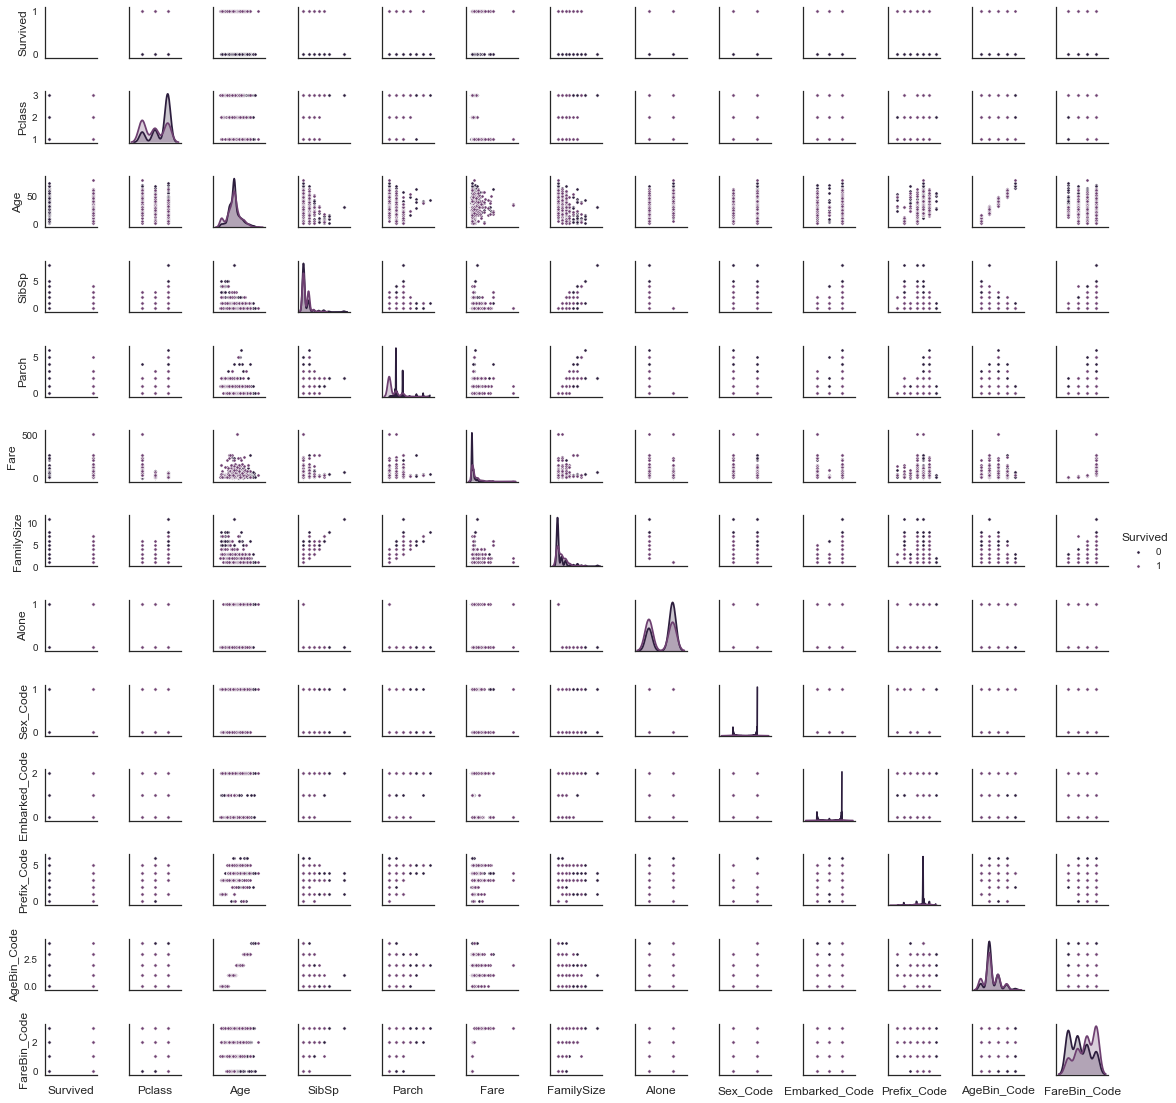

In [366]:
#dataset pairplot
pair_plot_colors = sns.cubehelix_palette(start = 0, n_colors = 5, reverse = True)
pp = sns.pairplot(training_data, hue = 'Survived', palette = pair_plot_colors, size=1.2, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10) )
pp.set(xticklabels=[])

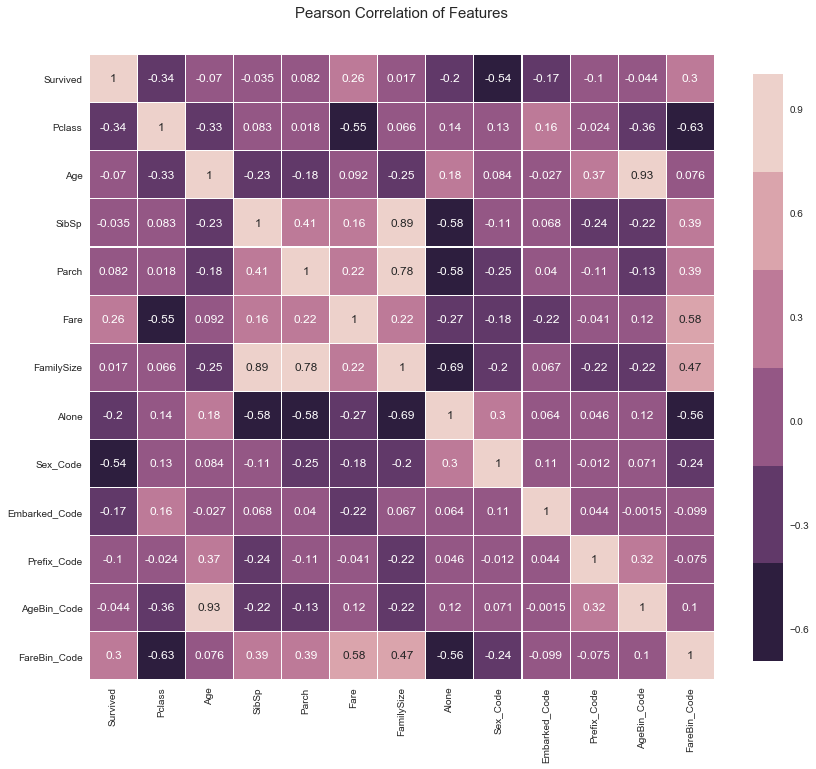

In [367]:
#correlation heatmap
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.cubehelix_palette(start = 0, n_colors = 6, reverse = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(training_data)

In [368]:
#Mahcine Learning Algorithm Selection and Initialization
MLA = [
    #Ensemble Methods
#    ensemble.AdaBoostClassifier(),
#    ensemble.BaggingClassifier(),
#    ensemble.ExtraTreesClassifier(),
#    ensemble.GradientBoostingClassifier(),
#    ensemble.RandomForestClassifier(),

    #Gaussian Processes
#    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
#    linear_model.LogisticRegressionCV(),
#    linear_model.PassiveAggressiveClassifier(),
#    linear_model.RidgeClassifierCV(),
#    linear_model.SGDClassifier(),
#    linear_model.Perceptron(),
    
    #Navies Bayes
#    naive_bayes.BernoulliNB(),
#    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
#    neighbors.KNeighborsClassifier(),
    
    #SVM
#    svm.SVC(probability=True),
#    svm.NuSVC(probability=True),
#    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
#    discriminant_analysis.LinearDiscriminantAnalysis(),
#    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
#    XGBClassifier()    
    ]



#data split for cross validaton
#this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = training_data[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, training_data[training_data_x_bin], training_data[Target], cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(training_data[training_data_x_bin], training_data[Target])
    MLA_predict[MLA_name] = alg.predict(training_data[training_data_x_bin])
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
0,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.818657,0.0596968,0.00220006
1,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.808582,0.0623358,0.00311999


In [1]:
#Remember, the name of the game is to create subgroups using a decision tree model to get 
#survived/1 in one bucket and dead/0 in another bucket. 
#Our rule of thumb will be the majority rules. Meaning, if the majority or 50% or more survived, 
#then everybody in our subgroup survived/1, but if 50% or less survived then if everybody in 
#our subgroup died/0. Also, we will stop if the subgroup is less than 10 and/or our model accuracy 
#plateaus or decreases.

#Question 1: Were you on the Titanic? If Yes, then majority (62%) died. 
#Note our sample survival is different than our population of 68%. Nonetheless, 
#if we assumed everybody died, our sample accuracy is 62%.

#Question 2: Are you male or female? Male, majority (81%) died. Female, majority (74%) survived. 
#Giving us an accuracy of 79%.

#Question 3A (going down the female branch with count = 314): Are you in class 1, 2, or 3? 
#Class 1, majority (97%) survived and Class 2, majority (92%) survived. Since the dead subgroup 
#is less than 10, we will stop going down this branch. Class 3, is even at a 50-50 split. 
#No new information to improve our model is gained.

#Question 4A (going down the female class 3 branch with count = 144): Did you embark from port 
#C, Q, or S? We gain a little information. C and Q, the majority still survived, so no change. 
#Also, the dead subgroup is less than 10, so we will stop. S, the majority (63%) died. So, we will 
#change females, class 3, embarked S from assuming they survived, to assuming they died. Our model 
#accuracy increases to 81%.

#Question 5A (going down the female class 3 embarked S branch with count = 88): So far, it looks 
#like we made good decisions. Adding another level does not seem to gain much more information. 
#This subgroup 55 died and 33 survived, since majority died we need to find a signal to identify 
#the 33 or a subgroup to change them from dead to survived and improve our model accuracy. We can play 
#with our features. One I found was fare 0-8, majority survived. It's a small sample size 11-9, 
#but one often used in statistics. We slightly improve our accuracy, but not much to move us past 82%. 
#So, we'll stop here.

#Question 3B (going down the male branch with count = 577): Going back to question 2, we know the 
#majority of males died. So, we are looking for a feature that identifies a subgroup that majority 
#survived. Surprisingly, class or even embarked didn't matter like it did for females, 
#but title does and gets us to 82%. Guess and checking other features, none seem to push us past 82%. 
#So, we'll stop here for now.

#You did it, with very little information, we get to 82% accuracy. On a worst, bad, good, better, 
#and best scale, we'll set 82% to good, since it's a simple model that yields us decent results. 
#But the question still remains, can we do better than our handmade model?

In [370]:
#handmade data model using brain power (and Microsoft Excel Pivot Tables for quick calculations)
def mytree(df):
    
    #initialize table to store predictions
    Model = pd.DataFrame(data = {'Predict':[]})
    male_title = ['Master'] #survived titles

    for index, row in df.iterrows():

        #Question 1: Were you on the Titanic; majority died
        Model.loc[index, 'Predict'] = 0

        #Question 2: Are you female; majority survived
        if (df.loc[index, 'Sex'] == 'female'):
                  Model.loc[index, 'Predict'] = 1

        #Question 3A Female - Class and Question 4 Embarked gain minimum information

        #Question 5B Female - FareBin; set anything less than .5 in female node decision tree back to 0       
        if ((df.loc[index, 'Sex'] == 'female') & 
            (df.loc[index, 'Pclass'] == 3) & 
            (df.loc[index, 'Embarked'] == 'S')  &
            (df.loc[index, 'Fare'] > 8)

           ):
                  Model.loc[index, 'Predict'] = 0

        #Question 3B Male: Title; set anything greater than .5 to 1 for majority survived
        if ((df.loc[index, 'Sex'] == 'male') &
            (df.loc[index, 'Prefix'] in male_title)
            ):
            Model.loc[index, 'Predict'] = 1
        
        
    return Model


#model data
Tree_Predict = mytree(training_data)
print('Decision Tree Model Accuracy/Precision Score: {:.2f}%\n'.format(metrics.accuracy_score(training_data['Survived'], Tree_Predict)*100))

print(metrics.classification_report(training_data['Survived'], Tree_Predict))

Decision Tree Model Accuracy/Precision Score: 82.04%

             precision    recall  f1-score   support

          0       0.82      0.91      0.86       549
          1       0.82      0.68      0.75       342

avg / total       0.82      0.82      0.82       891



Confusion matrix, without normalization
[[497  52]
 [108 234]]
Normalized confusion matrix
[[0.91 0.09]
 [0.32 0.68]]


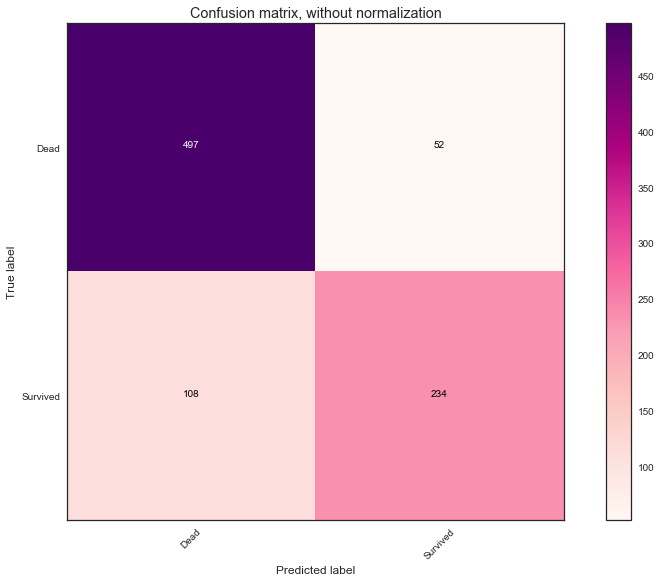

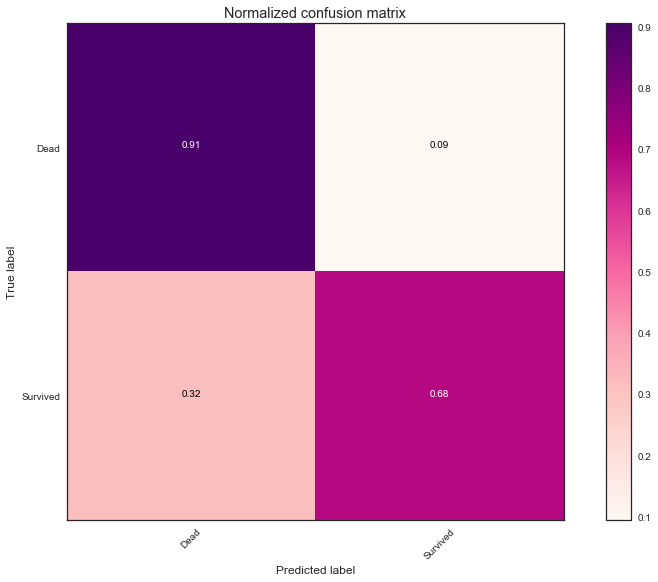

In [385]:
#Plot Accuracy Summary
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.RdPu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(training_data['Survived'], Tree_Predict)
np.set_printoptions(precision=2)

class_names = ['Dead', 'Survived']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

In [383]:
#model the submission
#print(validation_data.info())
#print("-"*10)

#homemade decision tree
validation_data['Survived'] = mytree(validation_data).astype(int)

#submit file
submit = validation_data[['PassengerId','Survived']]
submit.to_csv("submit.csv", index=False)

print('Validation Data Distribution: \n', validation_data['Survived'].value_counts(normalize = True))
submit.sample(10)



Validation Data Distribution: 
 0    0.662679
1    0.337321
Name: Survived, dtype: float64


,PassengerId,Survived
262,1154,1
410,1302,1
344,1236,1
187,1079,0
44,936,1
384,1276,0
24,916,1
192,1084,1
258,1150,1
33,925,0
